In [1]:
import numpy as np
import pandas as pd
import helper_functions as hf
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import utils

import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

compat_rename = {'Ultimate Tensile Strength': 'Tensile Strength, Ultimate',
                 'Yield Strength': 'Tensile Strength, Yield',
                 'Elongation': 'Elongation at Break',
                 'names': 'Name'}

In [2]:
nickel_data = pd.read_csv("final_test.csv", index_col=0)
nickel_data = nickel_data.drop(columns=["Name","URL", "Unnamed: 46", "Density"])
# nickel_data = nickel_data.rename(columns={"Name":"name"})
nickel_data.head()

,"Tensile Strength, Ultimate","Tensile Strength, Yield",Elongation at Break,Al,B,C,Cr,Fe,Mn,Ni,...,Pb,O,Re,Se,Ag,Zn,Nd,Pd,Ru,Th
0,1440.0,1265.0,5.3,4.5,0.01,0.05,16.0,3.0,0.5,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,490.0,248.0,23.0,0.0,0.00,0.01,22.0,3.0,0.5,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,970.0,565.0,42.0,0.4,0.00,0.10,21.0,5.0,0.5,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,620.0,410.0,42.0,0.0,0.00,0.05,25.0,0.0,0.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,895.0,490.0,43.8,0.4,0.00,0.10,21.0,5.0,0.5,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Train for Elongation

In [3]:
# uts_data = nickel_data.dropna(subset="Tensile Strength, Ultimate")
# uts_data = uts_data.drop(
#     columns=['Tensile Strength, Yield', 'Elongation at Break'])
# uts_data = uts_data.fillna(0)
# uts_data = uts_data.astype("float32")

elong_data = nickel_data.dropna(subset='Elongation at Break')
elong_data = elong_data.drop(columns=['Tensile Strength, Ultimate', "Tensile Strength, Yield"])
elong_data = elong_data.fillna(0)
elong_data = elong_data.astype("float32")

elong_data.head()

,Elongation at Break,Al,B,C,Cr,Fe,Mn,Ni,Si,Y,...,Pb,O,Re,Se,Ag,Zn,Nd,Pd,Ru,Th
0,5.300000,4.5,0.01,0.05,16.0,3.0,0.5,75.0,0.20,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23.000000,0.0,0.00,0.01,22.0,3.0,0.5,56.0,0.08,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42.000000,0.4,0.00,0.10,21.0,5.0,0.5,62.0,0.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,42.000000,0.0,0.00,0.05,25.0,0.0,0.0,65.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,43.799999,0.4,0.00,0.10,21.0,5.0,0.5,62.0,0.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:

elong_train_data = elong_data.sample(frac=0.8, random_state=2212)
elong_test_data = elong_data.drop(elong_train_data.index)

elong_data.head()

,Elongation at Break,Al,B,C,Cr,Fe,Mn,Ni,Si,Y,...,Pb,O,Re,Se,Ag,Zn,Nd,Pd,Ru,Th
0,5.300000,4.5,0.01,0.05,16.0,3.0,0.5,75.0,0.20,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23.000000,0.0,0.00,0.01,22.0,3.0,0.5,56.0,0.08,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42.000000,0.4,0.00,0.10,21.0,5.0,0.5,62.0,0.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,42.000000,0.0,0.00,0.05,25.0,0.0,0.0,65.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,43.799999,0.4,0.00,0.10,21.0,5.0,0.5,62.0,0.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
elong_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Elongation at Break,1357.0,2.670208e+01,16.810169,0.5,13.900,24.000000,37.25,118.000000
Al,1357.0,1.568567e+00,2.001722,0.0,0.020,0.500000,2.50,25.004999
B,1357.0,1.540427e-02,0.210405,0.0,0.000,0.004000,0.01,7.500000
C,1357.0,7.875976e-02,0.373737,0.0,0.021,0.050000,0.09,13.001000
Cr,1357.0,1.569177e+01,7.188942,0.0,13.630,17.030001,20.00,49.500000
Fe,1357.0,7.020707e+00,10.664334,0.0,0.000,2.000000,9.00,50.000000
Mn,1357.0,3.224970e-01,0.598835,0.0,0.000,0.100000,0.50,14.250500
Ni,1357.0,5.927720e+01,13.764413,20.0,53.160,57.410000,63.00,100.000000
Si,1357.0,2.755899e-01,0.676747,0.0,0.000,0.080000,0.40,19.000500
Y,1357.0,1.240397e-02,0.112890,0.0,0.000,0.000000,0.00,1.968556


In [6]:
elong_train_features = elong_train_data.copy()
elong_test_features = elong_test_data.copy()

elong_train_labels = elong_train_features.pop('Elongation at Break')
elong_test_labels = elong_test_features.pop('Elongation at Break')

In [7]:
elong_normalizer = hf.normalize(elong_train_features)

First example: [[ 0.    0.    0.3   0.    2.5   2.   63.    0.5   0.    0.    0.    0.
   0.    0.    0.    0.    0.   31.    0.    0.    0.04  0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]]

Normalized: [[-0.78 -0.07  0.59 -2.18 -0.42  2.8   0.27  0.33 -0.11 -0.07 -0.75 -0.89
  -0.42 -0.2  -0.62 -0.43 -0.03  5.43 -0.03 -0.05  3.11 -0.29 -0.1  -0.1
  -0.06 -0.04 -0.03 -0.21 -0.06 -0.05 -0.13 -0.04 -0.04 -0.03 -0.04 -0.03
   0.    0.   -0.06]]


In [8]:
def builder(hp): return hf.model_builder_variable(hp,
                                                  elong_normalizer,
                                                  test_layers=[1,2,3],
                                                  dropout=0.5,
                                                  layer_1_nodes=[50,100,150,200,250],
                                                  layer_2_nodes=[50,100,150,200,250],
                                                  layer_3_nodes=[50,100,150,200,250])

In [9]:
# tuner = kt.RandomSearch(builder,
#                      objective='val_loss',
#                      max_trials=100,
#                      overwrite=True,
#                      directory='model_search',
#                      project_name='yield_model')

tuner = kt.Hyperband(builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     overwrite=False,
                     directory='model_search',
                     project_name='elong_model_no_heat')

tuner_es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

INFO:tensorflow:Reloading Oracle from existing project model_search\elong_model_no_heat\oracle.json
INFO:tensorflow:Reloading Tuner from model_search\elong_model_no_heat\tuner0.json


In [10]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 4
hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1], 'ordered': True}
layer_1_nodes (Choice)
{'default': 10, 'conditions': [], 'values': [10], 'ordered': True}
layer_2_nodes (Choice)
{'default': 1, 'conditions': [], 'values': [1], 'ordered': True}
layer_3_nodes (Choice)
{'default': 1, 'conditions': [], 'values': [1], 'ordered': True}


In [11]:
# tuner.search(elong_train_features, elong_train_labels, epochs=200, validation_split=0.2, callbacks=[tuner_es], verbose=2)


In [12]:
# tuner.results_summary()

In [13]:
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
# best_hps.get_config()['values']

In [15]:
# elong_model = tuner.hypermodel.build(best_hps)

# elong_model.summary()

In [16]:
# es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

# history = yield_model.fit(yield_train_features, yield_train_labels, epochs=10000, callbacks=[es], validation_split=0.2, verbose=0)

# history = elong_model.fit(elong_train_features, elong_train_labels, epochs=10000, validation_split=0.2, verbose=0)

In [17]:
# elong_model.compile(loss='mean_squared_error',
#                     optimizer=tf.keras.optimizers.Nadam(0.001),
#                     metrics=[tf.keras.metrics.RootMeanSquaredError()])

# elong_model.save("models/elong_model_no_heat")

# elong_model.compile(loss='mean_squared_error',
#                     optimizer=tf.keras.optimizers.Nadam(0.001),
#                     metrics=[tf.keras.metrics.RootMeanSquaredError(),
#                             tf.keras.losses.MeanAbsoluteError()])

In [18]:
# elong_model.evaluate(elong_test_features, elong_test_labels, verbose=1)

In [19]:
# hf.plot_loss(history)

11/11 [==============================] - 0s 801us/step


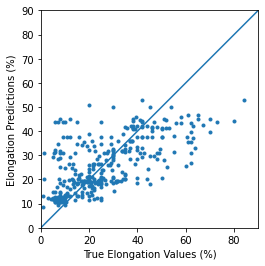

In [20]:
elong_model = tf.keras.models.load_model("models/elong_model_no_heat")

test_predictions = elong_model.predict(elong_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(elong_test_labels, test_predictions, marker=".")
plt.xlabel('True Elongation Values (%)')
plt.ylabel('Elongation Predictions (%)')
lims = [0, 90]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.savefig("pictures/elong_model_no_heat.pdf", bbox_inches='tight')